# Identifying Objects in Multi-Plant Images

Please note: this is not a workflow that should be followed all the way through for image analysis. This tutorial offers multiple possible workflows for identifying multiple objects in an image. You only need to use one in order to identify multiple objects.

Follow sections 1 and 2, then select only one subsection from section 3 to find multiple objects in your workflow.


# Section 1: Importing Image and Libraries 

In [2]:
# Import libraries
from plantcv import plantcv as pcv 
import numpy as np
import os

In [3]:
class options:
    def __init__(self):
        self.image = "multi_plant_image.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "multi_plant_results.txt"
        self.outdir = "."

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

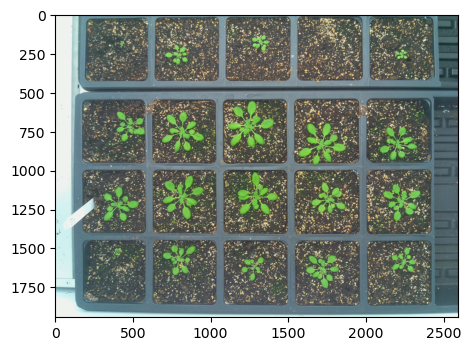

In [4]:
# Read image (sometimes you need to run this line twice to see the image) 

# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Isolating plant, making binary mask, getting object(s)¶
* Requires successful import of image
* See Isolating Plant Material Tutorial for a full list of functions that can be used to create a binary mask

In [5]:
#Increase text size and thickness to make labels clearer (size may need to
#be altered based on original image size)

pcv.params.text_size = 10
pcv.params.text_thickness = 20

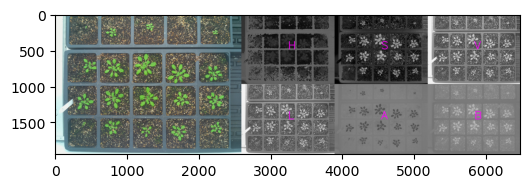

In [6]:
#Visualize colorspaces to select the channel which best isolated seeds
#from the background

# Inputs:
#   rbg_img = original image
colorspaces = pcv.visualize.colorspaces(rgb_img=img)

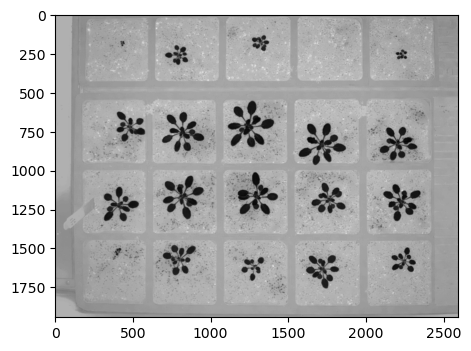

In [7]:
#Select a colorspace that best isolated seeds from background

# Inputs:
#   rbg_img = original image
#   channel = desired colorspace ('l', 'a', or 'b')
a = pcv.rgb2gray_lab(rgb_img = img, channel = 'a')

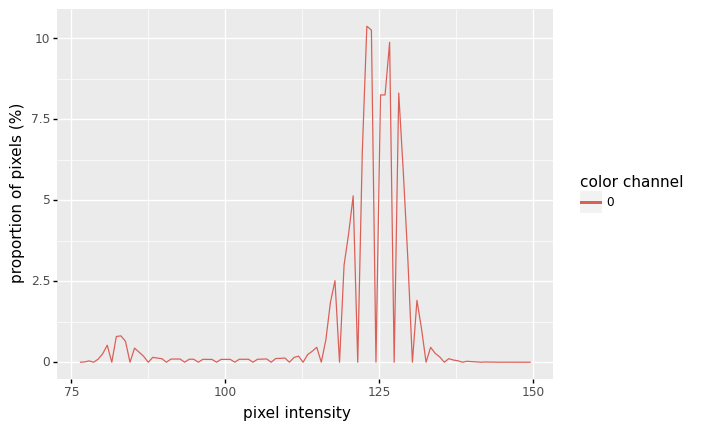

In [8]:
# Visualize histogram of colors within image

# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=a)

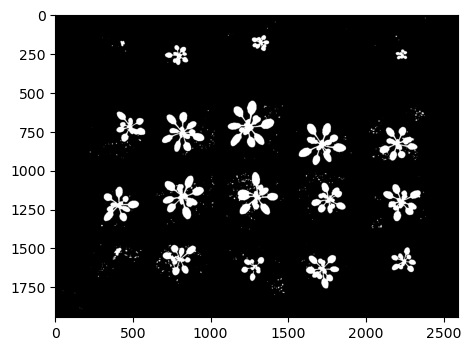

In [9]:
# Create binary mask for image

# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
a_thresh = pcv.threshold.binary(gray_img=a, threshold=110, max_value=255, object_type='dark')
#                                                      ^                                 ^
#                                                      |                                 |
#                                              change this value                  change this value

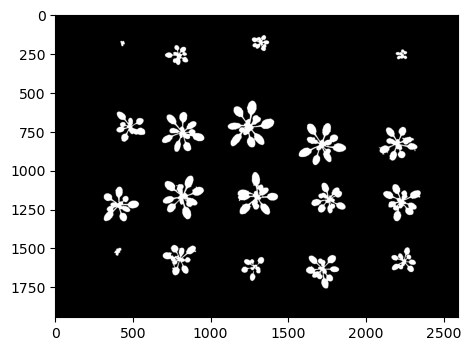

In [10]:
# Fill in small salt & pepper noise

# Inputs:
#   bin_img = Binary image data
#   size    = minimum object area size in pixels (integer), smaller objects will be filled
a_fill = pcv.fill(bin_img = a_thresh, size = 200)

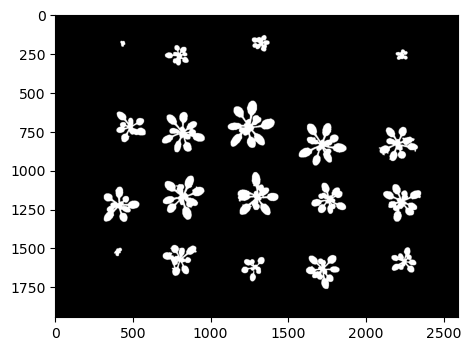

In [11]:
# Dilate so that you don't lose leaves (just in case)

# Inputs:
#    gray_img = input image
#    ksize    = kernel size, integer
#    i        = iterations, i.e. number of consecutive filtering passes

a_dilated = pcv.dilate(gray_img=a_fill, ksize=2, i=3)

# Section 3: Find Multiple Objects

* Need a completed binary mask 
* Each subsection has a different option for selecting multiple plants, you need to follow only one subsection to identify multiple objects

# Option 1: Using Cluster Contours

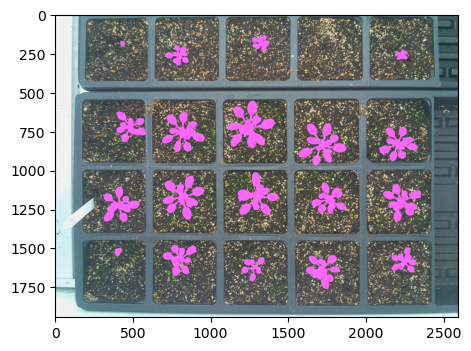

In [12]:
# Find objects (contours: black-white boundaries)

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=a_dilated)

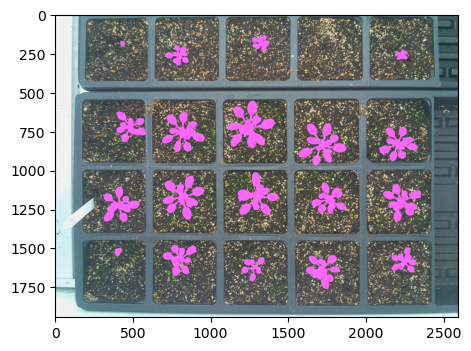

In [13]:
# Find objects (contours: black-white boundaries)

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=a_dilated)

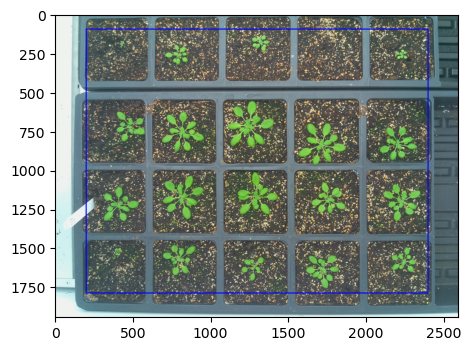

In [14]:
# Define region of interest (ROI)

# Inputs:
#    img   = img to overlay roi
#    x_adj = adjust center along x axis
#    y_adj = adjust center along y axis
#    h_adj = adjust height
#    w_adj = adjust width
# roi_contour, roi_hierarchy = pcv.roi.rectangle(img1, 10, 500, -10, -100)
#                                                      ^                ^
#                                                      |________________|
#                                            adjust these four values
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=200, y=90, h=1700, w=2200)

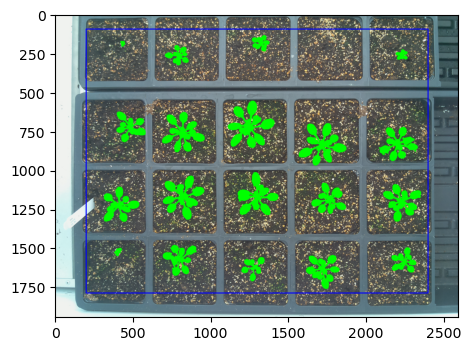

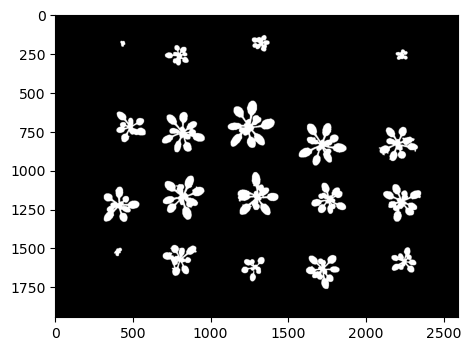

In [15]:
# Keep objects that overlap with the ROI

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from "Identifying Objects" function
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" function
#    roi_type       = 'partial' (default, for partially inside), 'cutto', or 'largest' (keep only largest contour)
roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi_contour, 
                                                                          roi_hierarchy=roi_hierarchy,
                                                                          object_contour=id_objects,
                                                                          obj_hierarchy=obj_hierarchy, 
                                                                          roi_type='partial')

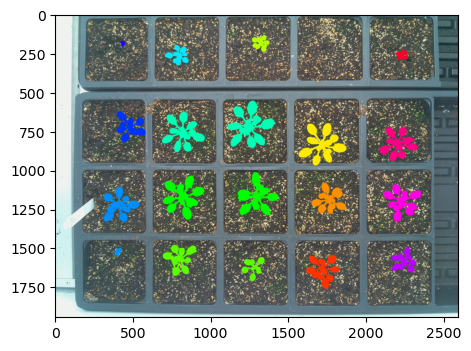

In [16]:
# This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB or grayscale image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of desired columns in the entire image even if there isn't a literal row of plants)
#    show_grid         = if True then a grid gets displayed in debug mode (default show_grid=False)
clusters_i, contours, hierarchies = pcv.cluster_contours(img=img, roi_objects=roi_objects, 
                                                             roi_obj_hierarchy=roi_obj_hierarchy, 
                                                             nrow=5, ncol=4)

In [24]:
# Takes clustered contours and splits them into multiple images,

# Inputs:
#    img                     = ideally a masked image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "print"

out = args.outdir

output_path, imgs, masks = pcv.cluster_contour_splitimg(img=img, grouped_contour_indexes=clusters_i, contours=contours, 
                                                        hierarchy=hierarchies, outdir=out, file=args.result, 
                                                        filenames=None)

pcv.params.debug = "plot"

This function has been updated to include object hierarchy so object holes can be included


This identifies different plants within an image and outputs each plant as a separate image and mask. For analysis, you will need to create a separate workflow containing the analyses desired (see shape and size workflows), and then parallelize this workflow across the set of images.

# Option 2: Using Multi ROI

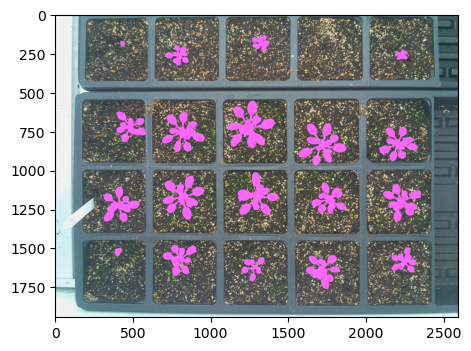

In [18]:
obj, obj_hierarchy = pcv.find_objects(img=img, mask=a_dilated)

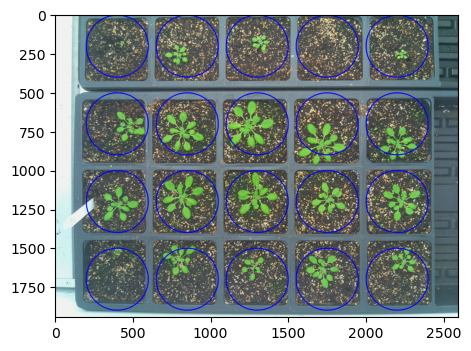

In [19]:
# Make a grid of ROIs

# Inputs:
#   img     = input image
#   coord   = top left coordinate to begin the ROI grid
#   radius  = radius for each ROI
#   spacing = spacing between each ROI
#   nrows   = number of rows in the ROI grid
#   ncols   = number of columns in the ROI grid
rois1, roi_hierarchy1 = pcv.roi.multi(img=img, coord=(400,200), radius=200, 
                                      spacing=(450, 500), nrows=4, ncols=5)

In [20]:
# Create a sequence of values to label each plant within the image

# Inputs:
#   start = beginning value for range
#   stop  = ending value for range (exclusive)
plant_id = range(0,len(rois1))

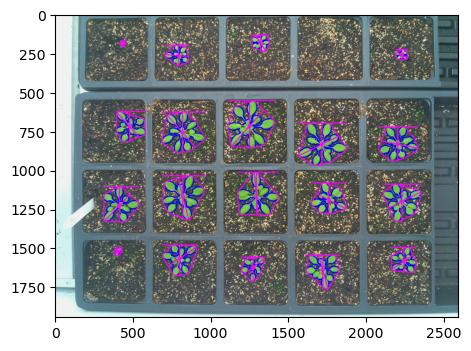

In [21]:
# Create a copy of the original image for annotations

# Inputs:
#   img = rgb image
img_copy = np.copy(img)

# Set debug to None (plotting all of the images would be very time consuming)
pcv.params.debug = None

# Create a for loop to interate through every ROI (plant) in the image
for i in range(0, len(rois1)):
    roi = rois1[i]
    hierarchy = roi_hierarchy1[i]
    id_label = plant_id[i]
    # Find objects
    filtered_contours, filtered_hierarchy, filtered_mask, filtered_area = pcv.roi_objects(
        img=img, roi_type="partial", roi_contour=roi, roi_hierarchy=hierarchy, object_contour=obj, 
        obj_hierarchy=obj_hierarchy)

    if filtered_area > 0:
        # Combine objects together in each plant     
        plant_contour, plant_mask = pcv.object_composition(img=img, contours=filtered_contours, hierarchy=filtered_hierarchy)        
        # Analyze the shape of each plant 
        img_copy = pcv.analyze_object(img=img_copy, obj=plant_contour, mask=plant_mask, label=id_label)

pcv.plot_image(img_copy)
pcv.print_image(img_copy, os.path.join(args.outdir, filename + "_shapes.jpg"))


Unlike Option 1, this example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using anayze_object. If other functions, for example color analysis, are desired, these should be included in the for loop.